# FullClass-TrainCNN_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=380
img_width=380
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


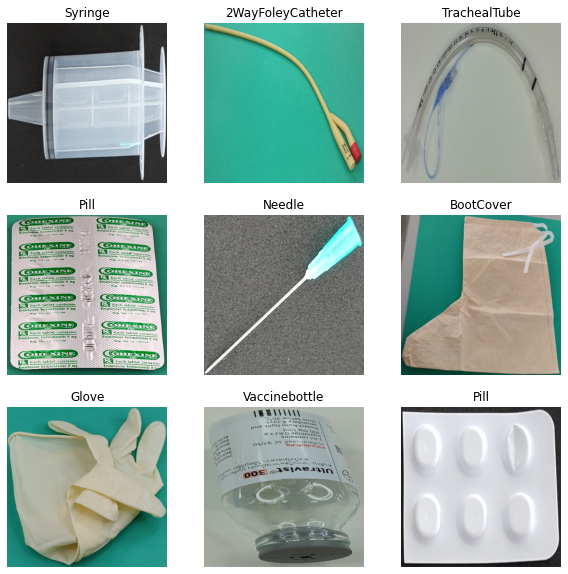

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 380, 380, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB4

efficientnetB0_model = keras.applications.EfficientNetB4(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB0_model_nooutput = efficientnetB0_model.layers[-3].output
custom_efficientnetB0_model = Model(inputs = efficientnetB0_model.input, outputs = efficientnetB0_model_nooutput)


78880768/78864416 [==============================] - 46s 1us/step


## Freez Extractor+

In [18]:
custom_efficientnetB0_model.trainable = False
for layer in custom_efficientnetB0_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_efficientnetB0_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(custom_efficientnetB0_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB0_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 1024)              1836032   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                42025     
Total params: 19,551,880
Trainable params: 1,878,057
Non-trainable params: 17,673,823
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/EfficientNetB4_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 75s 853ms/step - loss: 0.9439 - accuracy: 0.7447 - val_loss: 0.2525 - val_accuracy: 0.9314
Epoch 2/2000
49/49 [==============================] - 34s 693ms/step - loss: 0.1721 - accuracy: 0.9506 - val_loss: 0.1463 - val_accuracy: 0.9586
Epoch 3/2000
49/49 [==============================] - 34s 693ms/step - loss: 0.0840 - accuracy: 0.9796 - val_loss: 0.0984 - val_accuracy: 0.9677
Epoch 4/2000
49/49 [==============================] - 34s 693ms/step - loss: 0.0497 - accuracy: 0.9922 - val_loss: 0.1040 - val_accuracy: 0.9651
Epoch 5/2000
49/49 [==============================] - 34s 693ms/step - loss: 0.0413 - accuracy: 0.9887 - val_loss: 0.0913 - val_accuracy: 0.9677
Epoch 6/2000
49/49 [==============================] - 34s 694ms/step - loss: 0.0263 - accuracy: 0.9952 - val_loss: 0.0720 - val_accuracy: 0.9780
Epoch 7/2000
49/49 [==============================] - 34s 692ms/step - loss: 0.0178 - accuracy: 0.9968 - val_loss: 0.0728 - val_ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
49/49 [==============================] - 34s 692ms/step - loss: 8.8934e-04 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 0.9897
Epoch 202/2000
49/49 [==============================] - 34s 692ms/step - loss: 5.4255e-04 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 0.9897
Epoch 203/2000
49/49 [==============================] - 34s 692ms/step - loss: 8.1993e-04 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy: 0.9897
Epoch 204/2000
49/49 [==============================] - 34s 692ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0419 - val_accuracy: 0.9897
Epoch 205/2000
49/49 [==============================] - 34s 692ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.9897
Epoch 206/2000
49/49 [==============================] - 34s 692ms/step - loss: 9.0930e-04 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0.9897
Epoch 207/2000
49/49 [==============================] - 34s 692ms/step - loss: 6.9252e-04 - accuracy: 

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
49/49 [==============================] - 34s 693ms/step - loss: 3.9048e-04 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 0.9884
Epoch 402/2000
49/49 [==============================] - 34s 693ms/step - loss: 6.4956e-04 - accuracy: 0.9997 - val_loss: 0.0422 - val_accuracy: 0.9884
Epoch 403/2000
49/49 [==============================] - 34s 693ms/step - loss: 5.2932e-04 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 0.9884
Epoch 404/2000
49/49 [==============================] - 34s 693ms/step - loss: 4.0982e-04 - accuracy: 1.0000 - val_loss: 0.0423 - val_accuracy: 0.9884
Epoch 405/2000
49/49 [==============================] - 34s 693ms/step - loss: 4.0291e-04 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 0.9897
Epoch 406/2000
49/49 [==============================] - 34s 693ms/step - loss: 3.7174e-04 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 0.9897
Epoch 407/2000
49/49 [==============================] - 34s 693ms/step - loss: 3.1812e-04 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
49/49 [==============================] - 34s 689ms/step - loss: 2.4687e-04 - accuracy: 1.0000 - val_loss: 0.0415 - val_accuracy: 0.9884
Epoch 602/2000
49/49 [==============================] - 34s 690ms/step - loss: 2.6120e-04 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 0.9884
Epoch 603/2000
49/49 [==============================] - 34s 691ms/step - loss: 1.9060e-04 - accuracy: 1.0000 - val_loss: 0.0421 - val_accuracy: 0.9884
Epoch 604/2000
49/49 [==============================] - 34s 691ms/step - loss: 2.2304e-04 - accuracy: 1.0000 - val_loss: 0.0423 - val_accuracy: 0.9884
Epoch 605/2000
49/49 [==============================] - 34s 691ms/step - loss: 3.4102e-04 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9884
Epoch 606/2000
49/49 [==============================] - 34s 690ms/step - loss: 3.1489e-04 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 0.9897
Epoch 607/2000
49/49 [==============================] - 34s 691ms/step - loss: 2.2880e-04 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
49/49 [==============================] - 34s 693ms/step - loss: 2.0894e-04 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0.9897
Epoch 802/2000
49/49 [==============================] - 34s 693ms/step - loss: 1.4593e-04 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.9897
Epoch 803/2000
49/49 [==============================] - 34s 693ms/step - loss: 2.1947e-04 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.9897
Epoch 804/2000
49/49 [==============================] - 34s 693ms/step - loss: 2.2355e-04 - accuracy: 1.0000 - val_loss: 0.0422 - val_accuracy: 0.9897
Epoch 805/2000
49/49 [==============================] - 34s 693ms/step - loss: 7.1184e-04 - accuracy: 0.9997 - val_loss: 0.0416 - val_accuracy: 0.9897
Epoch 806/2000
49/49 [==============================] - 34s 693ms/step - loss: 5.9692e-04 - accuracy: 0.9997 - val_loss: 0.0406 - val_accuracy: 0.9897
Epoch 807/2000
49/49 [==============================] - 34s 693ms/step - loss: 3.1193e-04 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
49/49 [==============================] - 34s 692ms/step - loss: 2.1171e-04 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.9897
Epoch 1002/2000
49/49 [==============================] - 34s 693ms/step - loss: 1.6880e-04 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.9897
Epoch 1003/2000
49/49 [==============================] - 34s 693ms/step - loss: 1.6351e-04 - accuracy: 1.0000 - val_loss: 0.0404 - val_accuracy: 0.9897
Epoch 1004/2000
49/49 [==============================] - 34s 693ms/step - loss: 9.0493e-05 - accuracy: 1.0000 - val_loss: 0.0402 - val_accuracy: 0.9897
Epoch 1005/2000
49/49 [==============================] - 34s 693ms/step - loss: 1.2634e-04 - accuracy: 1.0000 - val_loss: 0.0404 - val_accuracy: 0.9897
Epoch 1006/2000
49/49 [==============================] - 34s 693ms/step - loss: 3.1420e-04 - accuracy: 1.0000 - val_loss: 0.0400 - val_accuracy: 0.9884
Epoch 1007/2000
49/49 [==============================] - 34s 693ms/step - loss: 1.8563e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
49/49 [==============================] - 34s 693ms/step - loss: 8.2737e-05 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy: 0.9871
Epoch 1202/2000
49/49 [==============================] - 34s 694ms/step - loss: 6.7917e-05 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 0.9871
Epoch 1203/2000
49/49 [==============================] - 34s 694ms/step - loss: 1.8510e-04 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9871
Epoch 1204/2000
49/49 [==============================] - 34s 694ms/step - loss: 6.8697e-05 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9871
Epoch 1205/2000
49/49 [==============================] - 34s 694ms/step - loss: 9.0641e-05 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0.9871
Epoch 1206/2000
49/49 [==============================] - 34s 694ms/step - loss: 9.5219e-05 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9871
Epoch 1207/2000
49/49 [==============================] - 34s 694ms/step - loss: 1.2811e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
49/49 [==============================] - 34s 693ms/step - loss: 6.4362e-05 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9897
Epoch 1402/2000
49/49 [==============================] - 34s 693ms/step - loss: 7.9342e-05 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.9897
Epoch 1403/2000
49/49 [==============================] - 34s 693ms/step - loss: 8.0216e-05 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.9897
Epoch 1404/2000
49/49 [==============================] - 34s 693ms/step - loss: 4.5878e-05 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9897
Epoch 1405/2000
49/49 [==============================] - 34s 693ms/step - loss: 5.8949e-05 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.9897
Epoch 1406/2000
49/49 [==============================] - 34s 693ms/step - loss: 1.0274e-04 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.9897
Epoch 1407/2000
49/49 [==============================] - 34s 694ms/step - loss: 5.5124e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
49/49 [==============================] - 34s 693ms/step - loss: 5.7611e-05 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9897
Epoch 1602/2000
49/49 [==============================] - 34s 694ms/step - loss: 4.8596e-05 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9897
Epoch 1603/2000
49/49 [==============================] - 34s 694ms/step - loss: 1.1135e-04 - accuracy: 1.0000 - val_loss: 0.0394 - val_accuracy: 0.9897
Epoch 1604/2000
49/49 [==============================] - 34s 694ms/step - loss: 6.5018e-05 - accuracy: 1.0000 - val_loss: 0.0394 - val_accuracy: 0.9897
Epoch 1605/2000
49/49 [==============================] - 34s 694ms/step - loss: 4.8514e-05 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9897
Epoch 1606/2000
49/49 [==============================] - 34s 694ms/step - loss: 1.8298e-04 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9897
Epoch 1607/2000
49/49 [==============================] - 34s 694ms/step - loss: 5.2212e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
49/49 [==============================] - 34s 693ms/step - loss: 3.6122e-05 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9897
Epoch 1802/2000
49/49 [==============================] - 34s 694ms/step - loss: 3.8552e-05 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy: 0.9897
Epoch 1803/2000
49/49 [==============================] - 34s 694ms/step - loss: 5.2031e-05 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy: 0.9897
Epoch 1804/2000
49/49 [==============================] - 34s 694ms/step - loss: 8.8257e-05 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9897
Epoch 1805/2000
49/49 [==============================] - 34s 694ms/step - loss: 4.5693e-05 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 0.9897
Epoch 1806/2000
49/49 [==============================] - 34s 694ms/step - loss: 2.5050e-04 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 0.9897
Epoch 1807/2000
49/49 [==============================] - 34s 694ms/step - loss: 5.4781e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

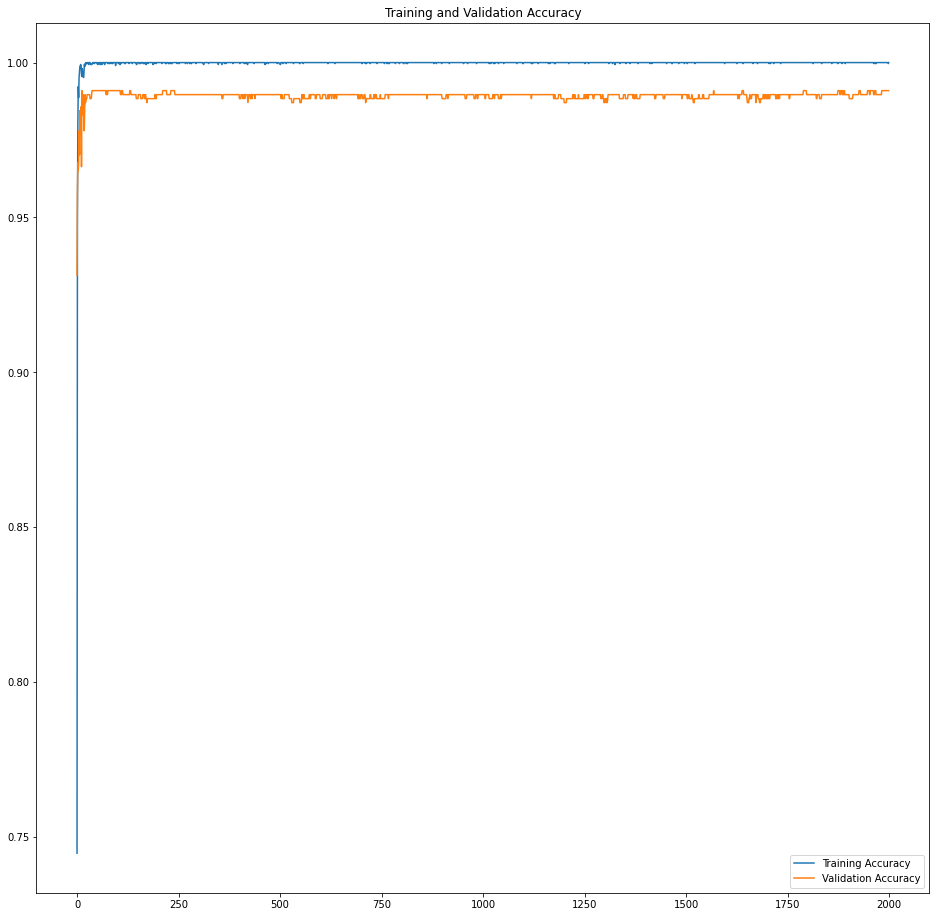

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


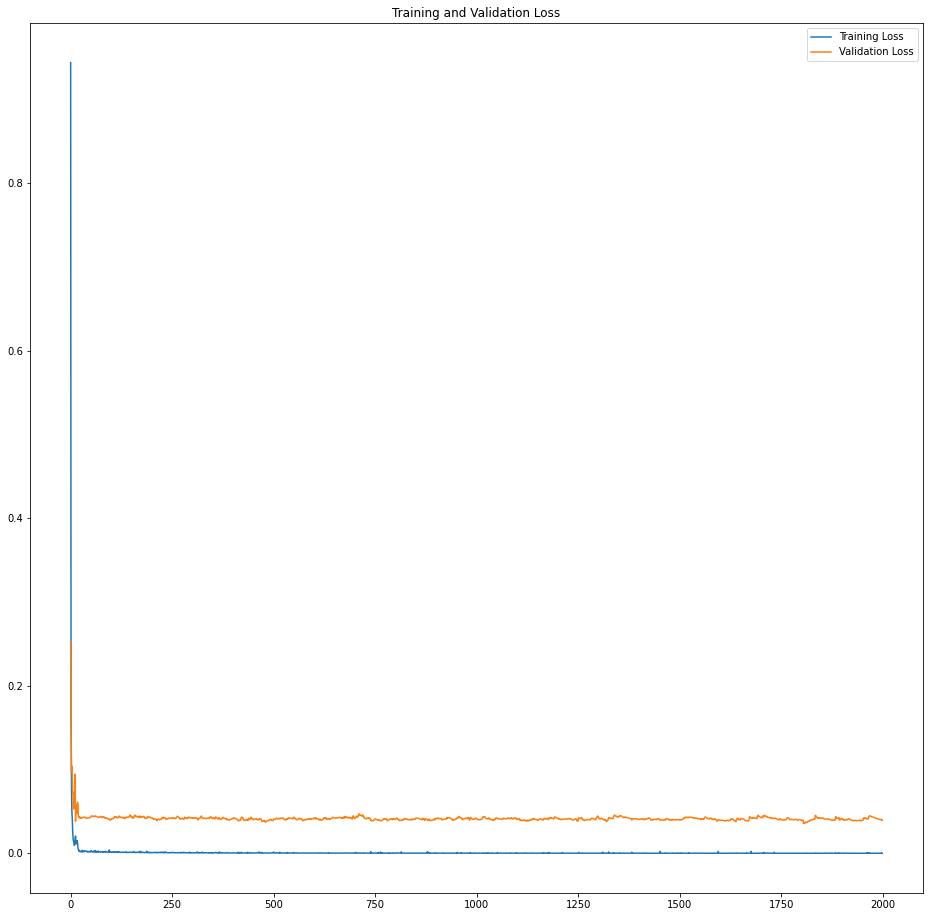

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 21s 565ms/step - loss: 0.4512 - accuracy: 0.9242
test_indoor_ds_results:test loss, test acc: [0.4511958658695221, 0.9241917729377747]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 33s 562ms/step - loss: 0.7818 - accuracy: 0.8395
test_outdoor_ds_results:test loss, test acc: [0.7817863821983337, 0.8394904732704163]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 22s 584ms/step - loss: 1.4215 - accuracy: 0.7756
test_belt_ds_results:test loss, test acc: [1.4215160608291626, 0.7756119966506958]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/EfficientNetB4_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB4_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB4_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB4_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB4_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoCl

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 19s 541ms/step - loss: 1.0729 - accuracy: 0.7801
Epoch200 
 test_indoor_acc=0.9225195050239563 
 test_outdoor_acc=0.831210196018219 
 test_belt_acc=0.7801450490951538


35/35 [==============================] - 19s 543ms/step - loss: 1.1467 - accuracy: 0.7788
Epoch400 
 test_indoor_acc=0.9225195050239563 
 test_outdoor_acc=0.8321655988693237 
 test_belt_acc=0.7787851095199585


35/35 [==============================] - 19s 539ms/step - loss: 1.1840 - accuracy: 0.7797
Epoch600 
 test_indoor_acc=0.9241917729377747 
 test_outdoor_acc=0.8315286636352539 
 test_belt_acc=0.779691755771637


35/35 [==============================] - 19s 539ms/step - loss: 1.2385 - accuracy: 0.7738
Epoch800 
 test_indoor_acc=0.9225195050239563 
 test_outdoor_acc=0.8318471312522888 
 test_belt_acc=0.7737987041473389


35/35 [==============================] - 19s 540ms/step - loss: 1.2648 - accuracy: 0.7779
Epoch1000 
 test_indoor_acc=0.9247491359710693 
 test_outdoor_acc=0.8324840664863586 
 test_belt_acc=0.7778785228729248


35/35 [==============================] - 19s 541ms/step - loss: 1.2838 - accuracy: 0.7788
Epoch1200 
 test_indoor_acc=0.9253065586090088 
 test_outdoor_acc=0.8318471312522888 
 test_belt_acc=0.7787851095199585


35/35 [==============================] - 19s 542ms/step - loss: 1.3074 - accuracy: 0.7838
Epoch1400 
 test_indoor_acc=0.9264214038848877 
 test_outdoor_acc=0.8308917284011841 
 test_belt_acc=0.7837715148925781


35/35 [==============================] - 19s 542ms/step - loss: 1.3471 - accuracy: 0.7801
Epoch1600 
 test_indoor_acc=0.9264214038848877 
 test_outdoor_acc=0.837579607963562 
 test_belt_acc=0.7801450490951538


35/35 [==============================] - 19s 545ms/step - loss: 1.3777 - accuracy: 0.7783
Epoch1800 
 test_indoor_acc=0.9258639812469482 
 test_outdoor_acc=0.8359872698783875 
 test_belt_acc=0.7783318161964417


35/35 [==============================] - 19s 542ms/step - loss: 1.4215 - accuracy: 0.7756
Epoch2000 
 test_indoor_acc=0.9241917729377747 
 test_outdoor_acc=0.8394904732704163 
 test_belt_acc=0.7756119966506958


In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

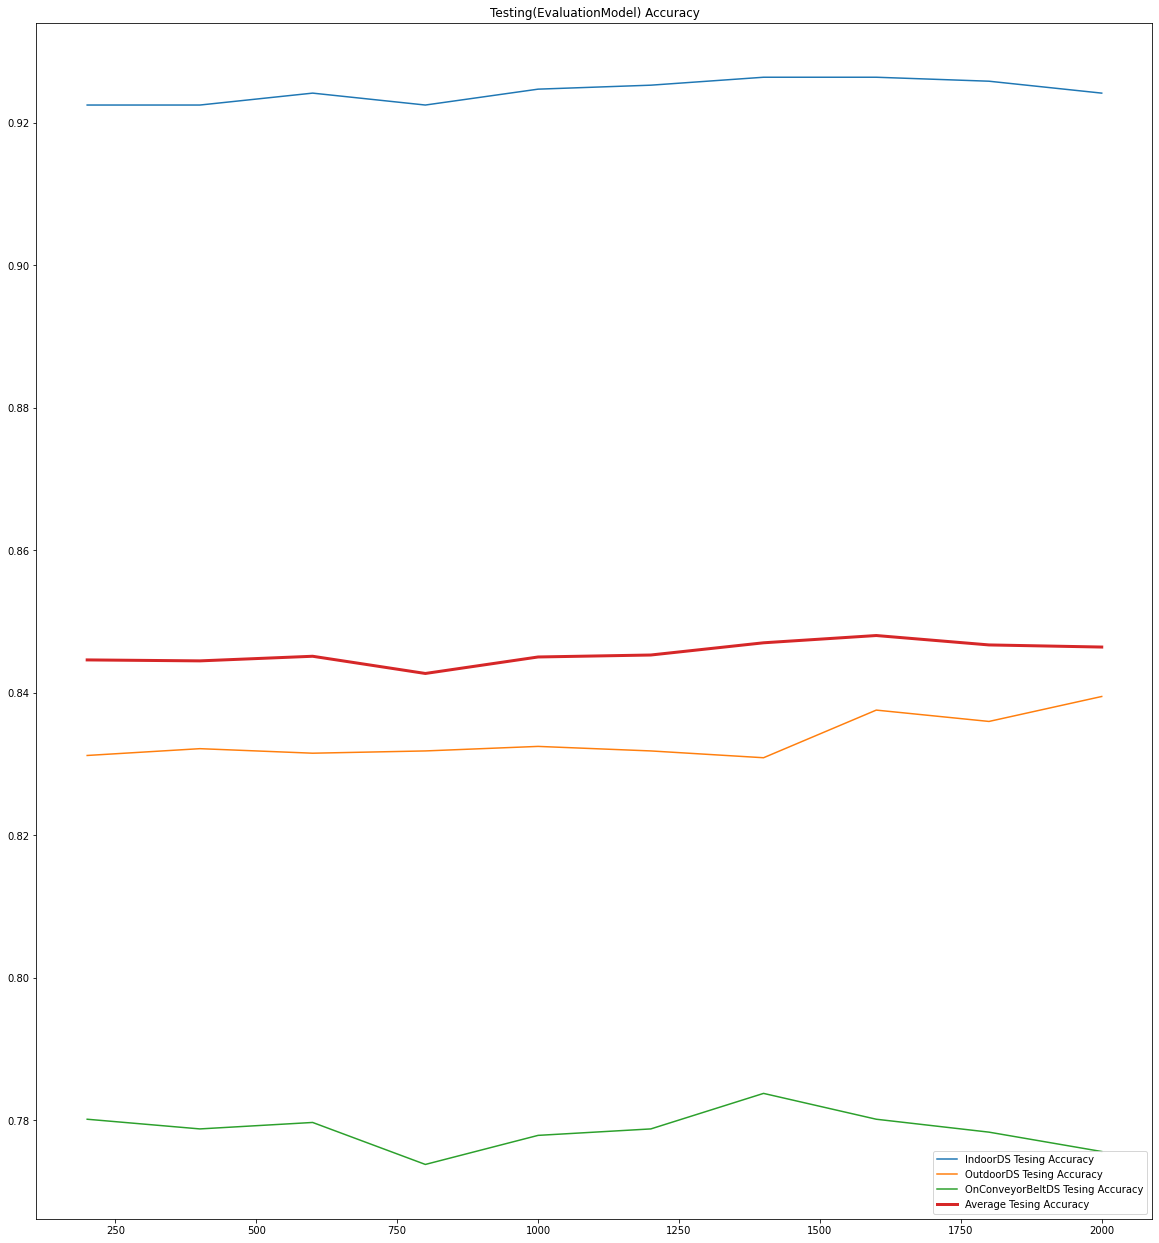

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.8480486869812012
max index -> 7
The [Epoch] of max acc -> 1600


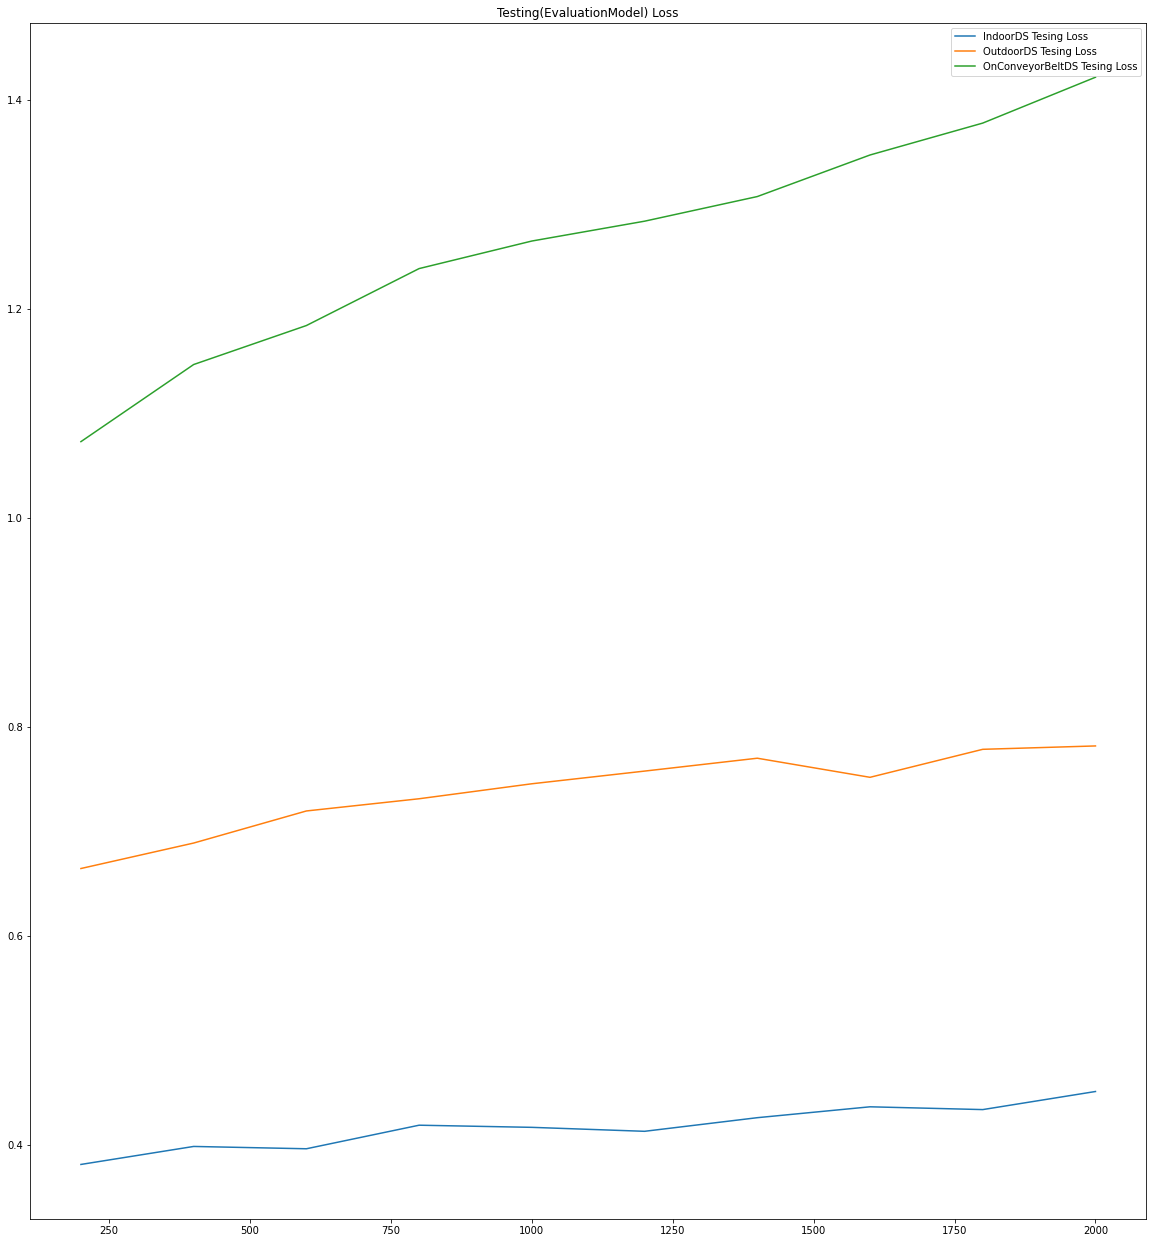

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.9225195050239563,
 0.9225195050239563,
 0.9241917729377747,
 0.9225195050239563,
 0.9247491359710693,
 0.9253065586090088,
 0.9264214038848877,
 0.9264214038848877,
 0.9258639812469482,
 0.9241917729377747]

In [38]:
test_outdoor_acc

[0.831210196018219,
 0.8321655988693237,
 0.8315286636352539,
 0.8318471312522888,
 0.8324840664863586,
 0.8318471312522888,
 0.8308917284011841,
 0.837579607963562,
 0.8359872698783875,
 0.8394904732704163]

In [39]:
test_belt_acc

[0.7801450490951538,
 0.7787851095199585,
 0.779691755771637,
 0.7737987041473389,
 0.7778785228729248,
 0.7787851095199585,
 0.7837715148925781,
 0.7801450490951538,
 0.7783318161964417,
 0.7756119966506958]

In [40]:
test_indoor_loss

[0.38141870498657227,
 0.3986321985721588,
 0.3964124619960785,
 0.41895592212677,
 0.4169072210788727,
 0.4131163954734802,
 0.426146000623703,
 0.4365612268447876,
 0.4338912069797516,
 0.4511958658695221]

In [41]:
test_outdoor_loss

[0.6645257472991943,
 0.6888877153396606,
 0.7195759415626526,
 0.7312623858451843,
 0.7455916404724121,
 0.7577223181724548,
 0.7700425982475281,
 0.7517741322517395,
 0.7785574793815613,
 0.7817863821983337]

In [42]:
test_belt_loss

[1.072899580001831,
 1.1466749906539917,
 1.1839685440063477,
 1.2384610176086426,
 1.2648226022720337,
 1.2838008403778076,
 1.3073698282241821,
 1.3471356630325317,
 1.3776617050170898,
 1.4215160608291626]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.efficientnet import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1600.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=380
img_width=380
batch_size=16

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  #ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
### VRAM not enough -> we split into N set
del x_test_indoor,x_test_outdoor,x_test_belt
N = 8
x_all_sets = np.array_split(x_all, N)
del x_all
y_all_sets_predicted = []
for x in x_all_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_all_predicted = np.concatenate(y_all_sets_predicted)
del x_all

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=6013
FP=1127
acc=0.842156862745098
all check = 7140


### acc

In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 87.06896551724138%
2WayConnectorforFoley acc = 93.19727891156462%
2WayFoleyCatheter acc = 82.08955223880598%
3WayConnectorforFoley acc = 94.87179487179486%
3Waystopcock acc = 98.1981981981982%
AlcoholBottle acc = 89.375%
AlcoholPad acc = 51.587301587301596%
BootCover acc = 69.87951807228916%
CottonBall acc = 92.21556886227546%
CottonSwap acc = 81.81818181818183%
Dilator acc = 85.47008547008546%
DisposableInfusionSet acc = 89.38053097345133%
ExtensionTube acc = 76.42276422764228%
FaceShield acc = 78.39506172839506%
FrontLoadSyringe acc = 53.98230088495575%
GauzePad acc = 68.18181818181817%
Glove acc = 76.78571428571429%
GuideWire acc = 50.0%
LiquidBottle acc = 75.57251908396947%
Mask acc = 99.22077922077922%
NGTube acc = 49.03225806451613%
NasalCannula acc = 63.716814159292035%
Needle acc = 91.42857142857143%
OxygenMask acc = 95.48872180451127%
PPESuit acc = 95.96774193548387%
PharmaceuticalProduct acc = 88.3177570093458%
Pill acc = 96.63865546218487%
PillBot

In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[101,   0,   0, ...,   0,   0,   0],
       [  0, 137,   0, ...,   0,   0,   0],
       [  0,   0, 110, ...,   0,   0,   9],
       ...,
       [  0,   0,   0, ..., 114,   0,   0],
       [  0,   0,   0, ...,   0, 204,   0],
       [  0,   0,   0, ...,   0,   0, 100]], dtype=int64)

In [7]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[87.06896552,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 93.19727891,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 82.08955224, ...,  0.        ,
         0.        ,  6.71641791],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 95.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        95.77464789,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 87.71929825]])

<AxesSubplot:>

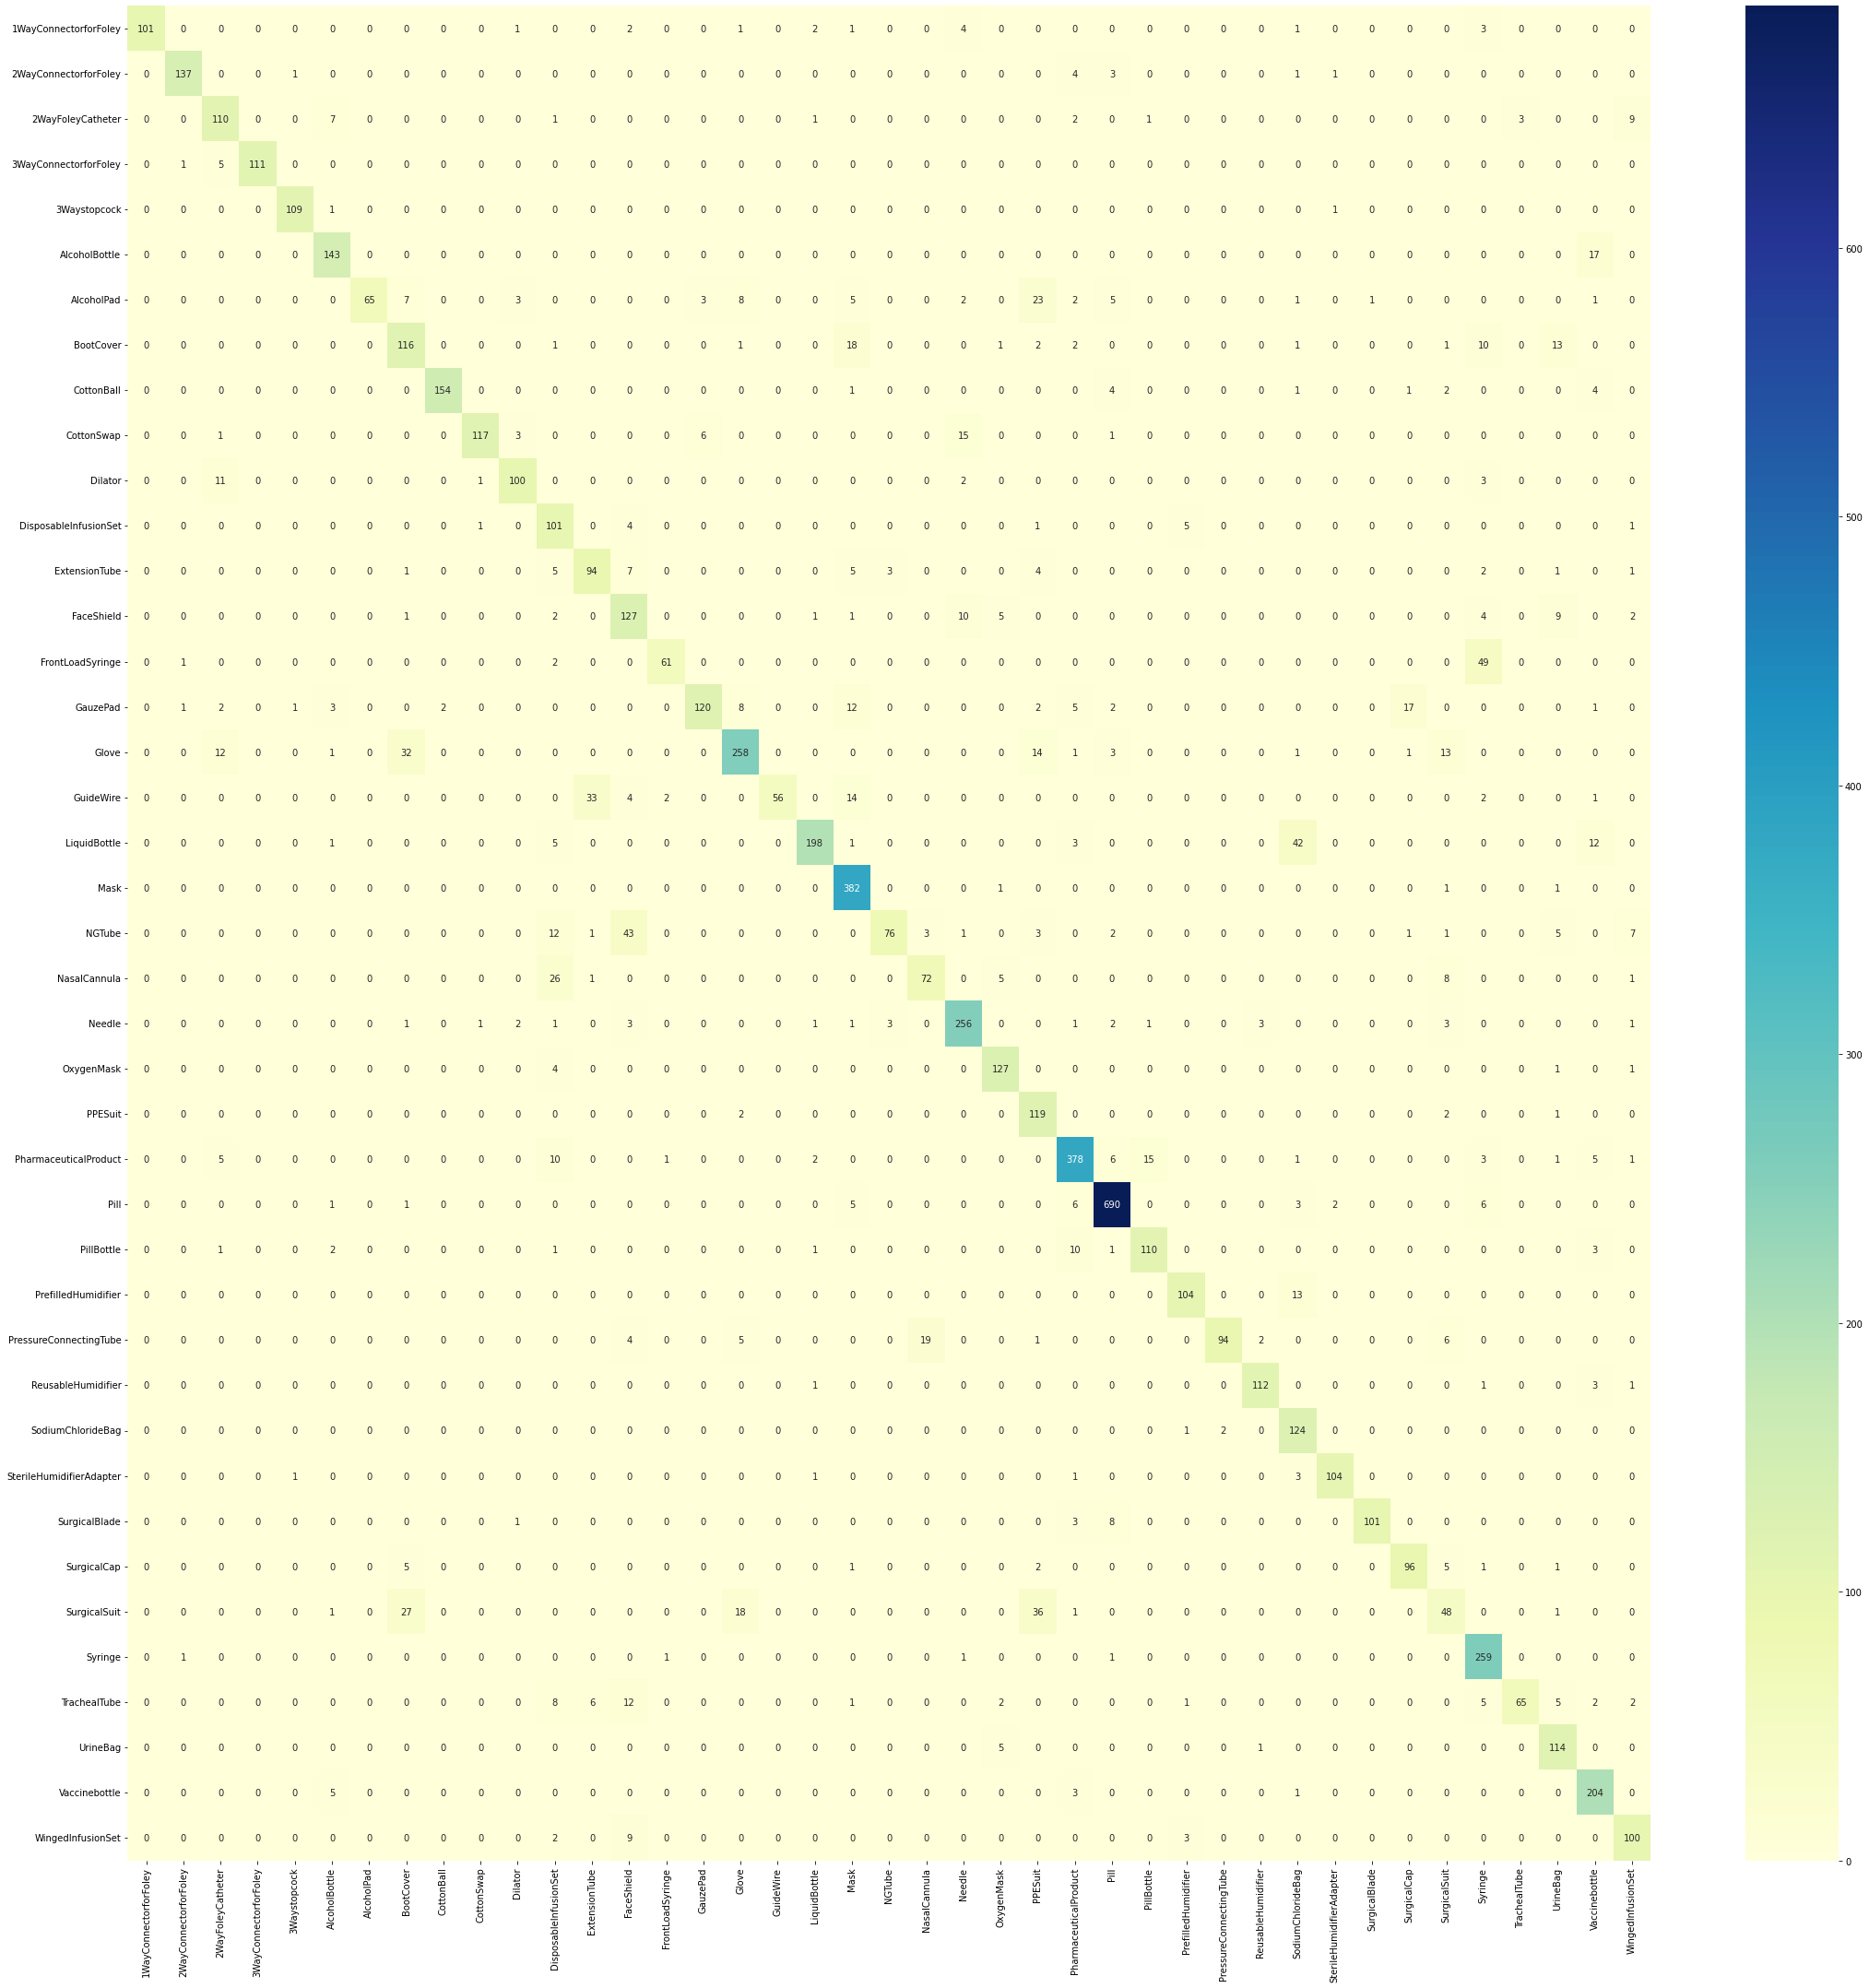

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

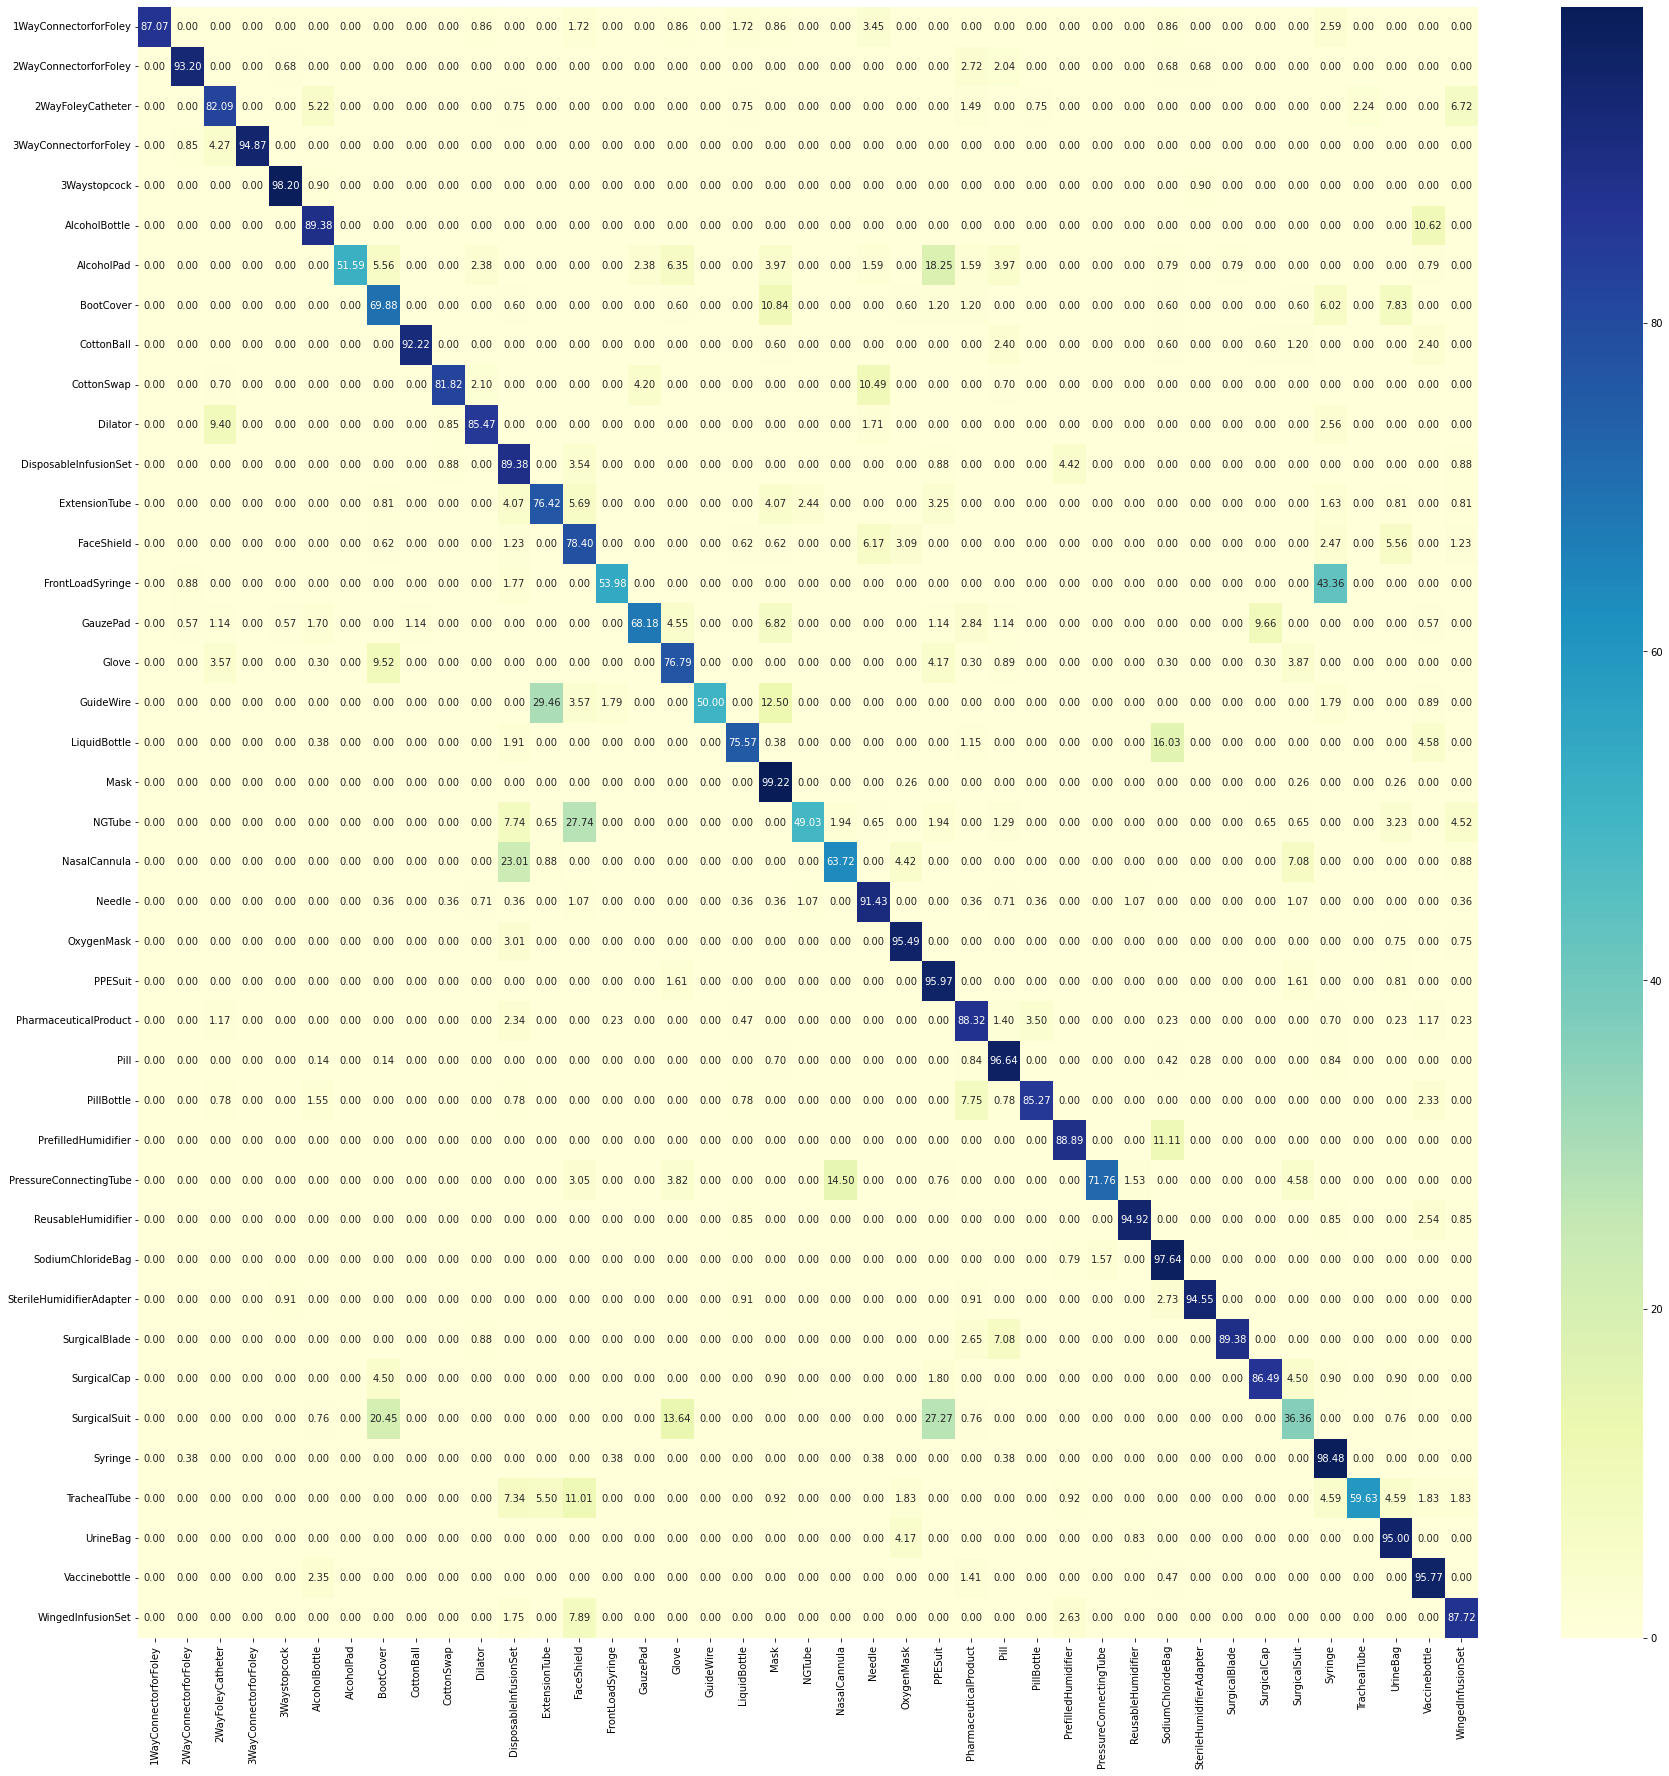

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")